In [3]:
import sys
sys.path.append('/scratch/ss4338/2020/')
import xarray as xr
import numpy as np
import pandas as pd
import dask
import xroms
import matplotlib.pyplot as plt

from track import track
from Interpolation import interpolation

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

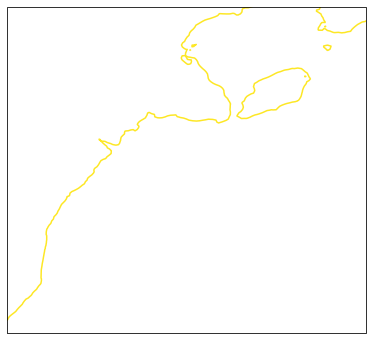

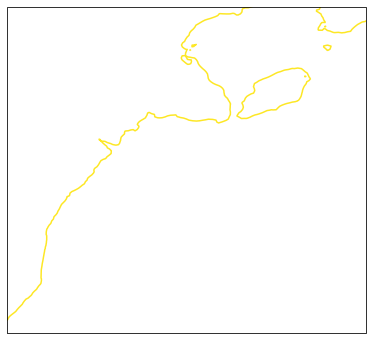

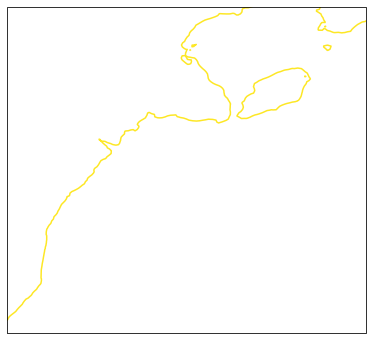

In [45]:
# pre-processing

# accessing dataset
link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/year_avg"
chunk = {"ocean_time":15}
ds = xroms.open_netcdf(link, chunks=chunk)

# bathymetry 

bathymetry = ds.h

extent = [-76,-65, 34, 44]
sigma = 15
lon_left = -75
lon_right = -70.65
isobath_value = 65
track_coords = track(ds, bathymetry, extent, lon_left, lon_right, isobath_value, sigma)

# track slices

AB_lon_lat, AB_ij = track_coords.AB_track(-0.74,50);
CD_lon_lat, CD_ij = track_coords.CD_track( 0.32,50);
BC_lon_lat, BC_ij = track_coords.BC_track();

#binding all slices of the track

final_ij_isobath = np.vstack((AB_ij[::-1], BC_ij, CD_ij))

final_lon_lat = np.vstack((AB_lon_lat[::-1], BC_lon_lat, CD_lon_lat))

lon_lat, ij_isobath = xr.DataArray(final_lon_lat), xr.DataArray(final_ij_isobath)
lon_lat, ij_isobath = lon_lat.rename({'dim_0':'along_track','dim_1':'lon_lat'}), ij_isobath.rename({'dim_0':'along_track', 'dim_1':'i_j'}) 



In [5]:
# creating mask

x1,y1 = AB_ij[0]
x2,y2 = AB_ij[-1]

m = (y2-y1)/(x2-x1)
y = y2-m*x2

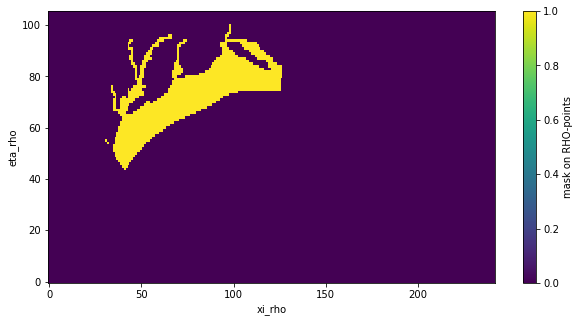

In [6]:
x1,y2 = CD_ij[0]
x2,y2 = CD_ij[-1]

m = (y2-y1)/(x2-x1)
x = (106 - y2)/m + x2

vertices1 = (0, y)  
vertices2 = (x,106)


import matplotlib.path as mpath

def create_mask(shape, polygon):
    y,x = np.mgrid[:shape[0], :shape[1]]
    points = np.column_stack((x.ravel(), y.ravel()))
    path = mpath.Path(polygon)
    mask = path.contains_points(points).reshape(shape)
    
    return mask

shape = (106, 242)
polygon = np.vstack((vertices1, final_ij_isobath, vertices2))
# polygon = final_ij_isobath


mask = create_mask(shape, polygon)
new_mask = (ds.mask_rho*mask)
new_mask.plot(figsize=(10,5))

In [57]:
temp = ds.temp*new_mask
volume = ds.dV*new_mask

In [61]:
volumetric_temp = ((temp*volume).sum(dim=['xi_rho','eta_rho','s_rho']))/(volume.sum(dim=['xi_rho','eta_rho','s_rho']))

Text(0.5, 1.0, 'calculated from annual data')

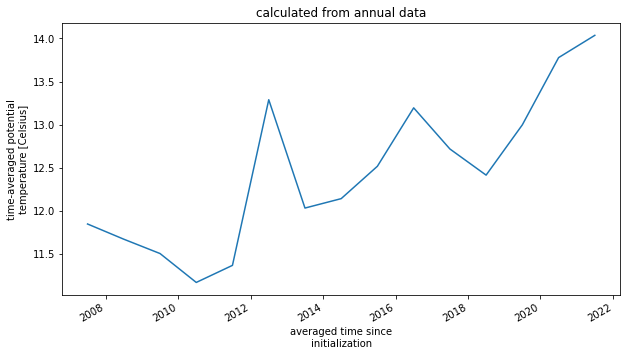

In [64]:
volumetric_temp.plot(figsize=(10,5))
plt.title('calculated from annual data')

In [66]:
# calculating dz and ds

track_instance = track_coords 
interpol = interpolation(ds, lon_lat, ij_isobath[:,0], ij_isobath[:,1], track_instance);

dz = interpol.dz() 

dS = xr.DataArray(interpol.delta_s(lon_lat), dims=['along_track'])

dz = dz.mean(dim='ocean_time')


# now you got dz, ds and volume from annual data you need to calculate other heat flux term.

In [69]:
# calculate air-sea flux time series

area = ds.dA*new_mask
air_sea_flux = ((ds.shflux*new_mask)*area).sum(dim=['xi_rho','eta_rho'])

Text(0, 0.5, 'air-sea heat transport [Watt]')

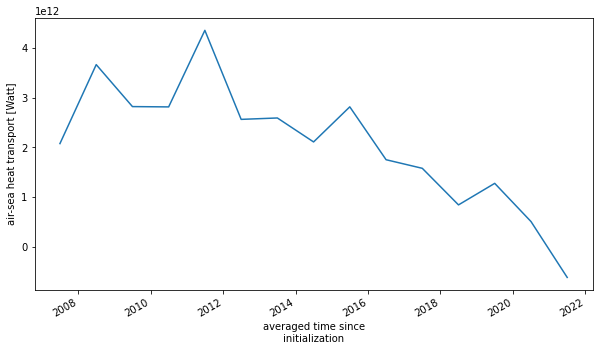

In [73]:
air_sea_flux.plot(figsize=(10,5))
plt.ylabel('air-sea heat transport [Watt]')

In [76]:
# calculation of heat transport from annual component
daily_data = xr.open_dataset('./daily_data.nc')

temp = daily_data.temp
nvel = daily_data.normal_vel

vel_corr = (nvel*dz*dS).sum(dim=['along_track','s_rho'])/(dz*dS).sum()

vel_corr = vel_corr.resample(ocean_time='Y').mean()

In [160]:
rho, cp = 1025, 3985 # volumetric heat capacity



T_annual = temp.resample(ocean_time='Y').mean(dim='ocean_time') - volumetric_temp.values

ValueError: operands could not be broadcast together with shapes (15,40,271) (15,) 

In [85]:
T_annual = temp.resample(ocean_time='Y').mean(dim='ocean_time')

In [97]:
T_annual - 

<xarray.DataArray 'temp' (ocean_time: 15, s_rho: 40, along_track: 271)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates: (12/15)
  * ocean_time  (ocean_time) datetime64[ns] 2007-12-31 2008-12-31 ... 2021-12-31
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (along_track) float64 ...
    lat_rho     (along_track) float64 ...
    z_rho0      (s_rho, along_track) float64 ...
    xi_rho      (along_track) float64 ...
    ...          ...
    z_rho_u0    (s_rho, along_track) float64 ...
    xi_u        (along_track) float64 ...
    lon_v       (along_track) float64 ...
    lat_v       (along_track) float64 ...
    z_rho_v0    (s_rho, along_track) float64 ...
    eta_v       (along_track) float64 ...
Dimensions without coordinates: along_track
Attributes:
    long_name:      time-averaged potential temperature
    units:          Celsius
    time:           ocean_time
    location:       face
    field:          temperature, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_potential_temperature

In [99]:
volumetric_temp

<xarray.DataArray (ocean_time: 15)>
dask.array<truediv, shape=(15,), dtype=float64, chunksize=(15,), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2007-07-01T18:00:00 ... 2021-07-0...
Attributes:
    long_name:      time-averaged potential temperature
    units:          Celsius
    time:           ocean_time
    field:          temperature, scalar, series
    cell_methods:   ocean_time: mean
    standard_name:  sea_water_potential_temperature
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

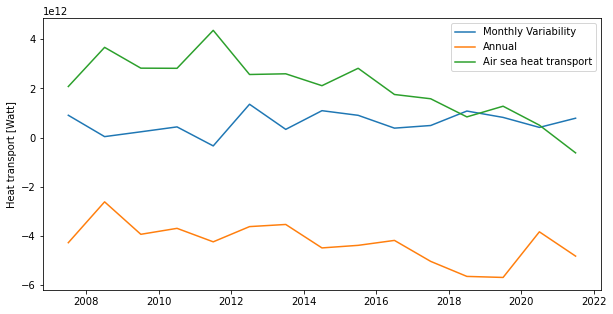

In [180]:


fig,ax = plt.subplots(figsize=(10,5))
ax.plot(ds.ocean_time, heat_monthly, label='Monthly Variability')
ax.plot(ds.ocean_time, heat_annual, label='Annual')
ax.set_ylabel('Heat transport [Watt]')
ax.plot(ds.ocean_time, air_sea_flux, label='Air sea heat transport')
ax.legend()

In [209]:
import gc; 
gc.collect()

u = nvel
t = temp

u_chunked = u.chunk({'ocean_time':100})
t_chunked = t.chunk({'ocean_time':100})

u_dash_list = []

for time in u_chunked.ocean_time:
    
    # extract year and month seperately to access perticular month data
    year = time.dt.year.values
    month = time.dt.month.values
    
    u_mon_specific = u_month.sel(ocean_time = f"{year}-{month}")
    u_chunked_specific = u_chunked.sel(ocean_time = time)
    u_dash = u_chunked_specific - u_mon_specific
    u_dash_list.append(u_dash)

u_dash = xr.concat(u_dash_list, dim='ocean_time')
    
    

In [210]:
u_dash

<xarray.DataArray 'normal_vel' (s_rho: 40, along_track: 271, ocean_time: 5475)>
dask.array<concatenate, shape=(40, 271, 5475), dtype=float64, chunksize=(40, 271, 1), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (along_track) float64 -75.65 -75.64 -75.62 ... -71.49 -71.49
    lat_rho     (along_track) float64 36.09 36.09 36.09 ... 41.34 41.35 41.36
  * ocean_time  (ocean_time) datetime64[ns] 2007-01-31 2007-01-31 ... 2021-12-31
    z_rho       (ocean_time, s_rho, along_track) float64 dask.array<chunksize=(1, 40, 271), meta=np.ndarray>
    z_rho0      (s_rho, along_track) float64 -13.99 -15.79 ... -0.1939 -0.1629
    ...          ...
    xi_u        (along_track) float64 34.53 34.65 34.77 ... 126.9 126.9 127.0
    lon_v       (along_track) float64 -75.68 -75.66 -75.65 ... -71.51 -71.52
    lat_v       (along_track) float64 36.11 36.11 36.11 ... 41.36 41.37 41.38
    z_rho_v     (ocean_time, s_rho, along_track) float64 dask.array<chunksize=(1, 40, 271), meta=np.ndarray>
    z_rho_v0    (s_rho, along_track) float64 -13.06 -14.8 ... -0.1357 -0.1173
    eta_v       (along_track) float64 50.68 50.53 50.38 ... 83.07 83.25 83.43
Dimensions without coordinates: along_track
Attributes:
    long_name:      Normal Component
    units:          meter second-1
    time:           ocean_time
    location:       edge1
    field:          u-velocity, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_x_velocity

In [211]:
t_dash_list = []

for time in t_chunked.ocean_time:
    
    # extract year and month seperately to access perticular month data
    year = time.dt.year.values
    month = time.dt.month.values
    
    t_mon_specific = t_month.sel(ocean_time = f"{year}-{month}")
    t_chunked_specific = t_chunked.sel(ocean_time = time)
    t_dash = t_chunked_specific - t_mon_specific
    t_dash_list.append(t_dash)

t_dash = xr.concat(t_dash_list, dim='ocean_time')
    

In [204]:
u_chunked = u.chunk({'ocean_time':100})
t_chunked = t.chunk({'ocean_time':100})

In [213]:
# year = u.ocean_time[0].dt.year.values
# month = u.ocean_time[45].dt.month.values

# u_month.sel(ocean_time = f"{year}-{month}")

In [217]:
heat_eddy = ((rho*cp*((-u_dash)*t_dash).resample(ocean_time='Y').mean(dim='ocean_time'))*dz*dS).sum(dim=['s_rho','along_track'])

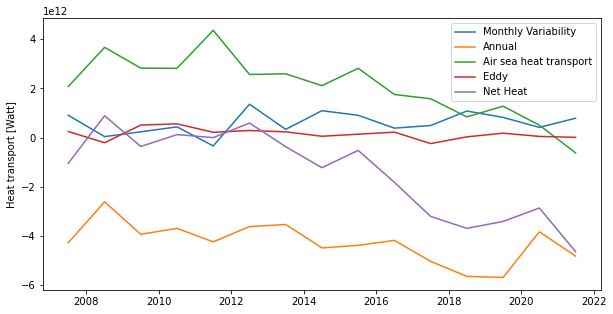

In [241]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(ds.ocean_time, heat_monthly, label='Monthly Variability')
ax.plot(ds.ocean_time, heat_annual, label='Annual')
ax.set_ylabel('Heat transport [Watt]')
ax.plot(ds.ocean_time, air_sea_flux, label='Air sea heat transport')
ax.plot(ds.ocean_time, heat_eddy, label='Eddy')
ax.plot(ds.ocean_time, Q_net, label='Net Heat')
ax.legend()

In [226]:
vol= (volume[0].sum()).values
vol

array(2.45922036e+12)

In [232]:
Q_air_sea = 2.183074e+12
Q_mean = -4.10976818e+12
Q_monthly = 9.06363249e+11
Q_eddy = 2.468643e+11

(((Q_air_sea + Q_mean + Q_monthly + Q_eddy )*(60*60*24*365))/(rho*cp*vol))

-2.4282788238359414

In [234]:
((-3.361657812027735 - (-2.4282788238359414))/(-3.361657812027735))*100

27.765437185552926

In [247]:
Q_net = (heat_monthly.values + heat_annual.values + air_sea_flux.values + heat_eddy.values)*(60*60*24*365)

In [287]:
vol = volume.sum(dim=['s_rho','eta_rho','xi_rho']).values

In [288]:
temp_diff = Q_net/(rho*cp*vol)

In [289]:
temp_diff

array([-3.27014582e+00,  2.78588779e+00, -1.13714582e+00,  3.81151951e-01,
       -8.79632736e-04,  1.85467532e+00, -1.16091639e+00, -3.84302994e+00,
       -1.63022687e+00, -5.71019398e+00, -1.00480915e+01, -1.15709381e+01,
       -1.06782126e+01, -8.96543830e+00, -1.45381789e+01])

In [252]:
link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/avg"
chunk = {"ocean_time":15}
ds = xroms.open_netcdf(link, chunks=chunk)
vol = ds.dV*new_mask 

In [254]:
temp = ds.temp*new_mask

In [284]:
vol_temp_diff = []
for i in np.arange(14):
    vol_temp_2 = (temp.isel(ocean_time=(i+1)*365)*vol.isel(ocean_time=(i+1)*365)).sum()/vol.isel(ocean_time=(i+1)*365).sum()
    vol_temp_1 = (temp.isel(ocean_time=(i)*365)*vol.isel(ocean_time=(i)*365)).sum()/vol.isel(ocean_time=(i)*365).sum()
    
    vol_diff = vol_temp_2.values - vol_temp_1.values
    vol_temp_diff.append(vol_diff)

In [291]:
vol_temp_diff

[-3.4219980559202607,
 0.740290327455785,
 -0.5915424306682748,
 -1.6173009380884134,
 4.466888316656482,
 -1.0858597024593468,
 -0.22465627772453622,
 -0.022063438135628388,
 2.9435286389247253,
 -2.679937571314788,
 -0.36628734555281284,
 -0.08157826915566524,
 -0.19611589640179083,
 1.707150403544878]

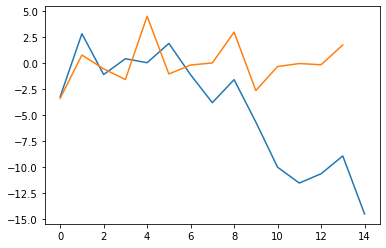

In [292]:
plt.plot(temp_diff)
plt.plot(vol_temp_diff)

In [258]:
vol_temp_1.values

array(12.15178564)

In [264]:
vol_temp_2.values

array(8.78109236)

In [271]:
vol_temp_3.values

array(9.47007791)

In [276]:
vol_temp_4.values

array(8.87853548)

In [265]:
(8.78109236 - 12.15178564)

-3.3706932799999993

In [273]:
9.47007791 - 12.15178564

-2.6817077299999994

In [277]:
8.87853548 - 9.47007791

-0.5915424300000005

In [274]:
temp.isel(ocean_time=3*365)

<xarray.DataArray (s_rho: 40, eta_rho: 106, xi_rho: 242)>
dask.array<getitem, shape=(40, 106, 242), dtype=float64, chunksize=(40, 106, 242), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (eta_rho, xi_rho) float64 -75.19 -75.13 -75.08 ... -64.62 -64.54
    lat_rho     (eta_rho, xi_rho) float64 32.24 32.28 32.32 ... 46.58 46.61
    ocean_time  datetime64[ns] 2010-01-01T12:00:00
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 235 236 237 238 239 240 241
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 99 100 101 102 103 104 105
    z_rho       (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(40, 106, 242), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(40, 106, 242), meta=np.ndarray>
Attributes:
    long_name:      time-averaged potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...
    location:       face
    field:          temperature, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_potential_temperature